In [3]:
import numpy as np
import pandas as pd
import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_validate
from autogluon.tabular import TabularDataset, TabularPredictor
import time
from rdkit import Chem
import toolsets.feature_engineering as fe
import toolsets.data_prep as data_prep
import toolsets.auto_rt_pred as ap
import seaborn as sns
from tqdm import tqdm
import toolsets.spectra_operations as so
%load_ext autoreload
%autoreload 2
import toolsets.helpers as helper
import toolsets.search as search

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# below cell is for preprocessing

In [4]:
data_binbase = pd.read_csv("/Users/fanzhoukong/Documents/GitHub/LC_binbase/bins_shen_hilic_pos_neg_nist.csv")
data_original = pd.read_csv("/Users/fanzhoukong/Documents/GitHub/LC_binbase/bins_shen_hilic_pos_neg.csv")
data = helper.pick_results_old(data_binbase, data_original,lowest_entropy_allowed = 0.5)
# data = helper.get_smiles(data)
# data = helper.get_class(data)
# data = data[~data['SMILES'].isnull()]
data =  data.loc[data['comments'].isin(['5m hilic | orbitrap | beh amide | negative', '5m hilic | orbitrap | beh amide | positive'])]

100%|██████████| 2149/2149 [00:01<00:00, 1138.44it/s]


In [47]:
helper.search.string_search(data, "library_inchi", "BXFFHSIDQOFMLE-UHFFFAOYSA-N")

,score,notes,instrument_type,comments,splash,precursormz,normalized_entropy,library_inchi,library_adduct,retention_time,entropy,msms,smiles
2,0.904654,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0059-9240000000-bdfa675ad1d767596591,212.002335,0.756018,BXFFHSIDQOFMLE-UHFFFAOYSA-N,[M-H]-,12.596388,1.354602,48.2187\t3133.33\n54.4944\t3158.54\n62.1300\t3...,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O
175,0.861258,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0059-9240000000-7623d347b57b5f05f4f7,212.002289,0.742727,BXFFHSIDQOFMLE-UHFFFAOYSA-N,[M-H]-,72.951261,1.445281,65.9736\t1271.91\n77.0008\t1236.33\n79.9446\t2...,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O
237,0.862196,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0059-9240000000-bd13ace26477c8317b30,212.002314,0.804673,BXFFHSIDQOFMLE-UHFFFAOYSA-N,[M-H]-,18.192422,1.441780,50.8280\t5351.85\n56.7371\t5011.81\n58.0517\t1...,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O
241,0.956128,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-01u0-9230000000-852e33afb4abaa89e741,211.999532,0.634497,BXFFHSIDQOFMLE-UHFFFAOYSA-N,[M-H]-,20.482020,1.136865,52.9986\t56486.92\n55.6674\t28755.83\n62.2556\...,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O
484,0.868942,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-01u0-9150000000-1fdf4650f868ce21822b,212.002304,0.782606,BXFFHSIDQOFMLE-UHFFFAOYSA-N,[M-H]-,17.767859,1.402241,47.3751\t1182.24\n47.5708\t2237.30\n48.3140\t2...,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O
576,0.776434,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0ugi-8290000000-0501cba0455ac90a974c,212.002306,0.729433,BXFFHSIDQOFMLE-UHFFFAOYSA-N,[M-H]-,32.413778,1.306969,48.5050\t691.49\n48.5246\t3904.50\n48.7265\t60...,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O
643,0.825855,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0059-9250000000-8d04d574d07d2c3f7d54,212.002294,0.777178,BXFFHSIDQOFMLE-UHFFFAOYSA-N,[M-H]-,17.756729,1.512318,48.1177\t7945.18\n48.6943\t443.28\n48.7464\t67...,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O
651,0.846367,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0059-9240000000-60ca421626c1fcd68c15,212.002306,0.762152,BXFFHSIDQOFMLE-UHFFFAOYSA-N,[M-H]-,17.502336,1.483079,47.4422\t1956.13\n47.4676\t7025.09\n48.5263\t7...,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O
702,0.896868,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0h0r-9270000000-576b7af5df9a528f2456,212.002282,0.758834,BXFFHSIDQOFMLE-UHFFFAOYSA-N,[M-H]-,18.200033,1.359649,48.6637\t2410.05\n50.1271\t2396.01\n50.2358\t6...,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O
703,0.930145,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0h0r-9270000000-215a813d00a17cd68294,212.002127,0.619076,BXFFHSIDQOFMLE-UHFFFAOYSA-N,[M-H]-,28.762508,1.204666,48.6934\t2021.14\n48.9754\t537.80\n50.5545\t67...,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O


<AxesSubplot:xlabel='retention_time', ylabel='Count'>

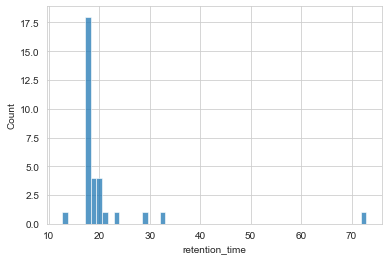

In [13]:
sns.histplot(helper.search.string_search(data, "library_inchi", "BXFFHSIDQOFMLE-UHFFFAOYSA-N")['retention_time'])

In [11]:
lib = pd.read_csv("/Users/fanzhoukong/Documents/GitHub/LC_binbase/5min_obitrap_beh/all_data_info-new.csv")

In [12]:
lib.head()

,db_id,inchikey,precursormz,precursor_type,entropy,name,smiles,db_name
0,CCMSLIB00000001547,IYDKWWDUBYWQGF,981.540394,[M+H]+,4.468333,3-Des-Microcystein_LR,CC1C(NC(=O)C(NC(=O)C(C(NC(=O)C(NC(=O)C(NC(=O)C...,gnps
1,CCMSLIB00000001548,KNGPFNUOXXLKCN,940.459233,[M+H]+,2.665666,Hoiamide B,CCCC(C)C(C(C)C1C(C(CC2=NC(=CS2)C3=NC(CS3)(C4=N...,gnps
2,CCMSLIB00000001549,WXDBUBIFYCCNLE,456.251127,[M+H]+,0.525565,Malyngamide C,CCCCCCCC(CC=CCCC(=O)NCC(=CCl)C12C(O1)C(CCC2=O)...,gnps
3,CCMSLIB00000001550,CGZKSPLDUIRCIO,545.149583,[M+H]+,1.862571,Scytonemin,C1=CC=C2C(=C1)C3=C(C(=O)C(=CC4=CC=C(C=C4)O)C3=...,gnps
4,CCMSLIB00000001554,WCNJVJCYRBJSLC,1025.606467,[M+H-H2O]+,4.013931,Cyclomarin A,CC1C(=O)NC(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(...,gnps


In [20]:
lib.head()

,db_id,inchikey,precursormz,precursor_type,entropy,name,smiles,db_name
0,CCMSLIB00000001547,IYDKWWDUBYWQGF,981.540394,[M+H]+,4.468333,3-Des-Microcystein_LR,CC1C(NC(=O)C(NC(=O)C(C(NC(=O)C(NC(=O)C(NC(=O)C...,gnps
1,CCMSLIB00000001548,KNGPFNUOXXLKCN,940.459233,[M+H]+,2.665666,Hoiamide B,CCCC(C)C(C(C)C1C(C(CC2=NC(=CS2)C3=NC(CS3)(C4=N...,gnps
2,CCMSLIB00000001549,WXDBUBIFYCCNLE,456.251127,[M+H]+,0.525565,Malyngamide C,CCCCCCCC(CC=CCCC(=O)NCC(=CCl)C12C(O1)C(CCC2=O)...,gnps
3,CCMSLIB00000001550,CGZKSPLDUIRCIO,545.149583,[M+H]+,1.862571,Scytonemin,C1=CC=C2C(=C1)C3=C(C(=O)C(=CC4=CC=C(C=C4)O)C3=...,gnps
4,CCMSLIB00000001554,WCNJVJCYRBJSLC,1025.606467,[M+H-H2O]+,4.013931,Cyclomarin A,CC1C(=O)NC(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(...,gnps


In [25]:
import toolsets.search as search

In [68]:
lib.shape

(4154670, 8)

In [22]:
smiles = []
for index, row in tqdm(data.iterrows(), total=len(data)):
    try:

        temp = search.string_search(lib,'inchikey', row['library_inchi'][0:14])
        smiles.append(temp.iloc[0]['smiles'])
        # smiles=np.append(smiles, temp.iloc[0]['smiles'])
    except:
        # smiles=np.append(smiles, np.NAN)
        smiles.append(np.NAN)
data['smiles']= smiles
data = data[~data['smiles'].isnull()]

100%|██████████| 1209/1209 [00:52<00:00, 22.88it/s]


In [33]:
data.reset_index(inplace=True, drop=True)

In [23]:
del(lib)

In [101]:
start = time.time()
descriptors_all = pd.read_csv("/Users/fanzhoukong/Documents/GitHub/LC_binbase/lcbinbase/all_unique_descriptors.csv"
                              ,skiprows=range(1,560000)
                              )
end = time.time()
print(end-start)

28.943816900253296


In [102]:
23+25

48

In [97]:
# 21.064022064208984, skip first 660000
# 122.30155205726624, no skip
# 20.851746082305908, skip first 660000 and only read next 1
# 28.943816900253296, skip 560000

,smiles,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,...,MID_C,AMID_C,MID_N,AMID_N,MID_O,AMID_O,MID_X,AMID_X,Vabc,mZagreb1
0,C1=CC(=C(C=C1F)NC(=O)CCl)F,9.480117,8.930615,0,0,6,6,19,13,0,...,16.284218,1.252632,1.990910,0.153147,1.731849,0.133219,5.228949,0.402227,160.25522,5.694445
1,C1=CC(=C(C=C1Cl)NC(=O)CCl)Cl,9.480117,8.930615,0,0,6,6,19,13,0,...,16.284218,1.252632,1.990910,0.153147,1.731849,0.133219,5.228949,0.402227,178.54224,5.694445
2,CC1=CC=C(C=C1)NC(=O)C2=C(N=CC=C2)Cl,12.975211,10.974140,0,0,12,12,28,17,0,...,26.555735,1.562102,4.016533,0.236267,1.779313,0.104665,1.767920,0.103995,214.43095,5.805555
3,CN1CCNC1=S,5.128087,5.320836,0,0,0,0,15,7,0,...,7.705502,1.100786,4.014010,0.573430,0.000000,0.000000,0.000000,0.000000,103.25003,2.972222
4,C1C(=O)NC2=C(O1)C=C(C=C2)Cl,9.370728,7.960200,0,0,6,6,18,12,0,...,16.764977,1.397082,2.026560,0.168880,3.800164,0.316680,1.768832,0.147403,144.55386,3.944444


In [34]:
data_descriptors = pd.DataFrame()
for index, row in tqdm(data.iterrows(), total=len(data)):
    temp = search.string_search(descriptors_all, "smiles", row['smiles'])
    if len(temp)==0:
        break
    data_descriptors = pd.concat([data_descriptors, temp], axis=0)
data_descriptors.reset_index(inplace=True, drop=True)

100%|██████████| 1207/1207 [00:10<00:00, 115.59it/s]


In [45]:
del(descriptors_all)

In [32]:
data['retention_time']

0         9.545269
1        10.857703
2        12.596388
3        14.534856
4        14.604331
           ...    
1206    126.192690
1207     35.969883
1208    126.262252
1209    117.585112
1210    113.106085
Name: retention_time, Length: 1207, dtype: float64

In [31]:
data_descriptors['retention_time']

0         9.545269
1        10.857703
2        12.596388
3        14.534856
4        14.604331
           ...    
1202    115.543105
1203     14.037532
1204    110.192862
1205      7.766110
1206    126.192690
Name: retention_time, Length: 1207, dtype: float64

In [35]:
data_descriptors.insert(0, 'retention_time', data['retention_time'])

In [41]:
data_descriptors['method']=data['comments']

In [38]:
data_descriptors = data_descriptors.dropna(axis=1, how='any')

In [43]:
data_descriptors['method'].value_counts()

5m hilic | orbitrap | beh amide | negative    656
5m hilic | orbitrap | beh amide | positive    551
Name: method, dtype: int64

In [44]:
data_confirmed = fe.mislable_exclusion(data_descriptors, 'method',data_descriptors.drop(['retention_time','method','smiles'], axis=1).columns, 0.16)

k-fold: 100%|██████████| 100/100 [02:21<00:00,  1.42s/it]


In [49]:
data_confirmed[data_confirmed['smiles']=='C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O']

,retention_time,smiles,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,...,AMID_C,MID_N,AMID_N,MID_O,AMID_O,MID_X,AMID_X,Vabc,mZagreb1,method
45,18.192422,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O,11.002477,9.956986,1,0,9,10,21,14,...,1.204917,2.04857,0.146326,7.042454,0.503032,0.0,0.0,154.53227,5.145834,5m hilic | orbitrap | beh amide | negative
48,20.482020,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O,11.002477,9.956986,1,0,9,10,21,14,...,1.204917,2.04857,0.146326,7.042454,0.503032,0.0,0.0,154.53227,5.145834,5m hilic | orbitrap | beh amide | negative
108,17.767859,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O,11.002477,9.956986,1,0,9,10,21,14,...,1.204917,2.04857,0.146326,7.042454,0.503032,0.0,0.0,154.53227,5.145834,5m hilic | orbitrap | beh amide | negative
173,17.756729,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O,11.002477,9.956986,1,0,9,10,21,14,...,1.204917,2.04857,0.146326,7.042454,0.503032,0.0,0.0,154.53227,5.145834,5m hilic | orbitrap | beh amide | negative
176,17.502336,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O,11.002477,9.956986,1,0,9,10,21,14,...,1.204917,2.04857,0.146326,7.042454,0.503032,0.0,0.0,154.53227,5.145834,5m hilic | orbitrap | beh amide | negative
202,18.200033,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O,11.002477,9.956986,1,0,9,10,21,14,...,1.204917,2.04857,0.146326,7.042454,0.503032,0.0,0.0,154.53227,5.145834,5m hilic | orbitrap | beh amide | negative
208,17.753299,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O,11.002477,9.956986,1,0,9,10,21,14,...,1.204917,2.04857,0.146326,7.042454,0.503032,0.0,0.0,154.53227,5.145834,5m hilic | orbitrap | beh amide | negative
216,17.724353,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O,11.002477,9.956986,1,0,9,10,21,14,...,1.204917,2.04857,0.146326,7.042454,0.503032,0.0,0.0,154.53227,5.145834,5m hilic | orbitrap | beh amide | negative
217,18.169610,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O,11.002477,9.956986,1,0,9,10,21,14,...,1.204917,2.04857,0.146326,7.042454,0.503032,0.0,0.0,154.53227,5.145834,5m hilic | orbitrap | beh amide | negative
251,17.696314,C1=CC=C2C(=C1)C(=CN2)OS(=O)(=O)O,11.002477,9.956986,1,0,9,10,21,14,...,1.204917,2.04857,0.146326,7.042454,0.503032,0.0,0.0,154.53227,5.145834,5m hilic | orbitrap | beh amide | negative


In [221]:
data_confirmed_with_class=helper.get_class(data_confirmed, item = 'superclass')

100%|██████████| 217/217 [00:33<00:00,  6.39it/s]


In [52]:
data_confirmed_with_class = helper.get_class(data_confirmed, identifier_column='smiles', item='superclass')

100%|██████████| 255/255 [00:48<00:00,  5.30it/s]


In [53]:
value_counts = data_confirmed_with_class['superclass'].value_counts().rename_axis('super_class').reset_index(name='counts')

In [55]:
data_error = pd.read_csv("/Users/fanzhoukong/Documents/GitHub/LC_binbase/5min_obitrap_beh/core_retip_error.csv")

In [57]:
data_error=data_error.loc[data_error['delta retip']>0.2]

In [60]:
data_error_with_class = helper.get_class(data_error,identifier_column='smiles', item='superclass')

100%|██████████| 56/56 [00:11<00:00,  5.06it/s]


In [61]:
value_counts_error = data_error_with_class['superclass'].value_counts().rename_axis('super_class').reset_index(name='counts')

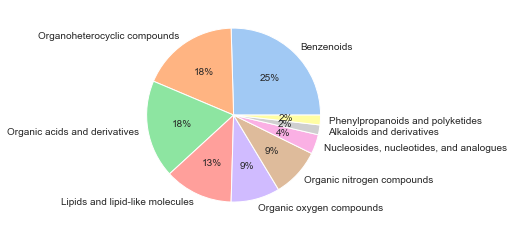

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette('pastel')[0:len(value_counts_error)]

#create pie chart
plt.pie(value_counts_error['counts'], labels = value_counts_error['super_class'], colors = colors,autopct='%.0f%%')
plt.show()

In [65]:
value_counts_error

,super_class,counts
0,Benzenoids,14
1,Organoheterocyclic compounds,10
2,Organic acids and derivatives,10
3,Lipids and lipid-like molecules,7
4,Organic oxygen compounds,5
5,Organic nitrogen compounds,5
6,"Nucleosides, nucleotides, and analogues",2
7,Alkaloids and derivatives,1
8,Phenylpropanoids and polyketides,1


In [75]:
value_counts_error.set_index('super_class', inplace=True)
value_counts.set_index('super_class', inplace=True)

value_counts = value_counts.reindex(value_counts_error.index)
value_counts.reset_index(inplace=True)
value_counts_error.reset_index(inplace=True)

In [236]:
import toolsets.classyfire as cls

In [80]:
value_counts = value_counts.dropna(subset=['counts'])

In [81]:
value_counts

,super_class,counts
0,Benzenoids,69.0
1,Organoheterocyclic compounds,148.0
2,Organic acids and derivatives,205.0
3,Lipids and lipid-like molecules,28.0
4,Organic oxygen compounds,124.0
5,Organic nitrogen compounds,9.0
7,Alkaloids and derivatives,5.0
8,Phenylpropanoids and polyketides,22.0


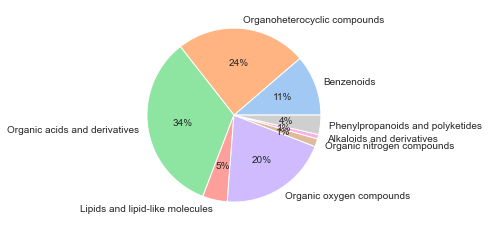

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette('pastel')[0:len(value_counts_error)]

#create pie chart
plt.pie(value_counts['counts'], labels = value_counts['super_class'], colors = colors,autopct='%.0f%%')
plt.show()

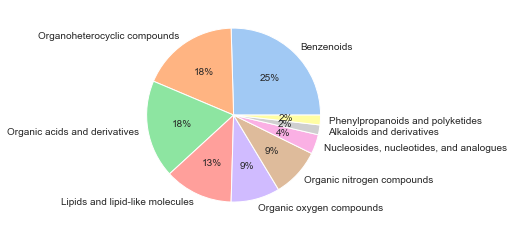

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette('pastel')[0:len(value_counts_error)]

#create pie chart
plt.pie(value_counts_error['counts'], labels = value_counts_error['super_class'], colors = colors,autopct='%.0f%%')
plt.show()

In [74]:
# features_all= fe.descriptors_prep(descriptors_table)

In [204]:
# features_complete = pd.DataFrame()
# for index, row in data.iterrows():
#     # print(row['SMILES'])
#     temp = descriptors_table_complete.loc[descriptors_table_complete['SMILES'] == row['SMILES']]
#     features_complete = pd.concat([features_complete, temp], axis=0)
#     # break
# features_complete = features_complete.drop(['SMILES'], axis=1)
# features_complete.reset_index(inplace=True, drop=True)
# data.reset_index(inplace=True, drop=True)
# data_hilic = pd.concat([data['retention_time'],data['comments'],data['SMILES'],features_complete], axis=1)
# data_hilic=data_hilic[data_hilic['comments'].isin(['5m hilic | orbitrap | beh amide | negative', '5m hilic | orbitrap | beh amide | positive']) ]

In [256]:
# features_complete_columns = features_complete.head(1)
# features_complete_columns.to_csv("data/descriptors.csv", index = False)

<AxesSubplot:xlabel='retention_time', ylabel='Count'>

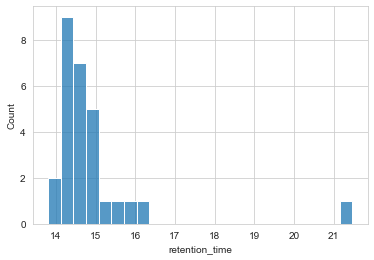

In [251]:
# sns.histplot(data_hilic_confirmed.loc[data_hilic_confirmed['SMILES']=='CC1=CC=C(C=C1)OS(=O)(=O)O']['retention_time'])

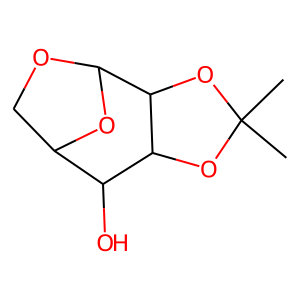

In [227]:
# from rdkit import Chem
# from rdkit.Chem import Draw
# Draw.MolToImage(Chem.MolFromSmiles('C1(OC2C(O1)C3OC(C2O)CO3)(C)C'), molsPerRow=6, subImgSize=(180, 180))

In [199]:
test_smiles = ['C1(=CC(=CC(=C1)O)O)O','C(C(CO)=O)(O)C(C(CO)O)O','C1(OC2C(O1)C3OC(C2O)CO3)(C)C']

In [207]:
df =df[features_complete.columns]

In [208]:
df.shape

(3, 1223)

In [26]:
# features_complete= features_complete.drop(['SMILES'], axis = 1)

In [205]:
data_hilic['comments'].value_counts()

5m hilic | orbitrap | beh amide | negative    655
5m hilic | orbitrap | beh amide | positive    552
Name: comments, dtype: int64

In [206]:
data_hilic_confirmed = fe.mislable_exclusion(data_hilic, 'comments',features_complete.columns, 0.16)

k-fold: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


In [210]:
data_hilic_confirmed_model = pd.concat([data_hilic_confirmed['retention_time'], data_hilic_confirmed[features_complete.columns]],axis=1)

In [215]:
model_68 = ap.autogluon_fit(data_hilic_confirmed_model, "model/nist_68")

Beginning AutoGluon training ...
AutoGluon will save models to "model/nist_68/"
AutoGluon Version:  0.4.1b20220423
Python Version:     3.9.0
Operating System:   Darwin
Train Data Rows:    819
Train Data Columns: 1223
Label Column: retention_time
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (142.92571346409505, 10.356760991096657, 65.8293, 40.87394)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3939.86 MB
	Train Data (Original)  Memory Usage: 8.01 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_me

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -7.843320       0.360999  64.236818                0.001153           0.090213            2       True         11
1              LightGBM  -8.063588       0.004823  16.806765                0.004823          16.806765            1       True          4
2            LightGBMXT  -8.271037       0.006871  23.709746                0.006871          23.709746            1       True          3
3        NeuralNetTorch  -8.743690       0.129258  23.556389                0.129258          23.556389            1       True          9
4              CatBoost  -8.845995       0.011362  15.233705                0.011362          15.233705            1       True          6
5       RandomForestMSE  -8.908946       0.021334   4.520840                0.021334           4.520840 

In [216]:
y_test = model_68.predict(df)

In [244]:
import math
MSE = np.square(np.subtract(y_train_pred,data_hilic_confirmed_model['retention_time'])).mean()

RMSE = math.sqrt(MSE)

In [246]:
RMSE

6.064484391752592

In [232]:
data_hilic_confirmed_model.drop(['retention_time'], axis=1)

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,13.202929,11.709699,0,0,20.712705,2.383498,4.742568,20.712705,1.218394,3.758938,...,9.663770,63.242131,253.052112,9.037575,535,22,88.0,100.0,6.506944,3.625000
1,16.258866,13.992746,1,0,27.060767,2.570531,5.010168,27.060767,1.288608,3.990142,...,10.236633,69.916593,287.152144,6.836956,825,38,114.0,140.0,7.229167,4.736111
2,16.876363,13.802273,1,0,26.819958,2.363597,4.727195,26.819958,1.219089,4.001163,...,9.931443,55.984242,318.065887,8.596375,1182,33,112.0,128.0,8.979167,4.763889
3,16.876363,13.802273,1,0,26.819958,2.363597,4.727195,26.819958,1.219089,4.001163,...,9.931443,55.984242,318.065887,8.596375,1182,33,112.0,128.0,8.979167,4.763889
4,14.470305,11.689063,1,0,25.010365,2.051411,4.102821,25.010365,1.190970,3.867121,...,8.687948,51.656682,296.235145,5.589342,1452,19,82.0,81.0,7.972222,5.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,11.510585,10.996419,1,1,17.319018,2.230897,4.461795,17.319018,1.082439,3.623846,...,9.194313,47.240747,257.102824,7.141745,522,16,72.0,73.0,8.736111,3.541667
815,8.485281,8.852607,0,1,15.575479,2.257545,4.515089,15.575479,1.198114,3.395871,...,8.920656,42.702008,186.221626,4.541991,284,16,52.0,56.0,6.062500,3.500000
816,11.510585,10.996419,1,1,17.319018,2.230897,4.461795,17.319018,1.082439,3.623846,...,9.194313,47.240747,257.102824,7.141745,522,16,72.0,73.0,8.736111,3.541667
817,6.163363,6.515899,1,3,9.335326,2.116883,4.233766,9.335326,1.037258,3.028326,...,8.267962,36.359125,131.069477,7.281638,96,8,36.0,36.0,5.583333,2.111111


In [233]:
y_train_pred = model_68.predict(data_hilic_confirmed_model.drop(['retention_time'], axis=1))

In [236]:
diff = pd.Series(y_train_pred-data_hilic_confirmed_model['retention_time'])

In [248]:
diff.mean()

-0.16293342739876848

In [249]:
import scipy.stats as st

In [250]:
st.t.interval(alpha=0.95, df=len(diff)-1, loc=np.mean(diff), scale=st.sem(diff))

(-0.5789892380089368, 0.25312238321139985)

In [241]:
diff.quantile(0.95)

8.175721969854031

In [228]:
y_test-124.44

0   -48.713394
1    -6.683594
2   -62.283192
Name: retention_time, dtype: float32

In [118]:

# team1 =  set(random.sample(all_players, 6))
# team2 = all_players - team1

In [122]:
from sklearn.model_selection import train_test_split

In [137]:
unique_smiles = data_hilic_confirmed['SMILES'].unique()
X1, X2 = train_test_split(unique_smiles, test_size=0.2)

In [ ]:
data_hilic_confirmed

In [145]:
data_hilic_model = pd.concat([data_hilic_confirmed['SMILES'], data_hilic_confirmed['retention_time'], data_hilic_confirmed[feature_importance.index[0:100]]], axis=1)

In [149]:
train = data_hilic_model[data_hilic_model['SMILES'].isin(X1)]
train = train.drop(['SMILES'], axis=1)

In [150]:
test = data_hilic_model[~data_hilic_model['SMILES'].isin(X1)]
test = test.drop(['SMILES'], axis=1)

In [151]:
ap.autogluon_fit_train_test(train,test, "subset_by_compounds")

Beginning AutoGluon training ...
AutoGluon will save models to "subset_by_compounds/"
AutoGluon Version:  0.4.1b20220423
Python Version:     3.9.0
Operating System:   Darwin
Train Data Rows:    856
Train Data Columns: 100
Label Column: retention_time
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (164.40302041275078, 0.0563704715822627, 61.5696, 40.2796)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4891.47 MB
	Train Data (Original)  Memory Usage: 0.68 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set featur

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        NeuralNetTorch -13.399883       0.033879  26.215434                0.033879          26.215434            1       True          9
1   WeightedEnsemble_L2 -13.399883       0.034024  26.304160                0.000145           0.088726            2       True         11
2         LightGBMLarge -15.226330       0.003202  20.172023                0.003202          20.172023            1       True         10
3            LightGBMXT -15.356639       0.006837   9.031007                0.006837           9.031007            1       True          3
4               XGBoost -15.467186       0.007888  10.741487                0.007888          10.741487            1       True          8
5         ExtraTreesMSE -15.608342       0.019951   0.280854                0.019951           0.280854 

In [140]:
len(train['SMILES'].unique())

262

In [141]:
len(test['SMILES'].unique())

66

In [ ]:
data_hilic_confirmed.unique()

In [160]:
data.loc[data['SMILES']=='CC1=CC=C(C=C1)OS(=O)(=O)O']

,score,notes,instrument_type,comments,splash,precursormz,normalized_entropy,library_inchi,library_adduct,retention_time,entropy,msms,SMILES,classes
0,0.933503,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-2900000000-e2d4228d01eb088edb4c,187.006927,0.585092,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,9.545269,0.642789,48.0717\t450267.34\n51.3891\t393197.50\n75.133...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
30,0.932428,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-1900000000-aeebd4cee644bd147192,187.006866,0.565701,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,34.647135,0.621487,55.1675\t330214.91\n67.8168\t299470.78\n79.957...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
54,0.934037,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-2910000000-ac641457b7f3075f4ca1,187.006927,0.591873,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,79.434094,0.650239,43.4719\t658597.44\n55.5859\t641756.81\n56.126...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
177,0.934291,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-2910000000-18c1d343e27d24d1c6a7,187.006882,0.592024,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,74.719501,0.650404,52.2323\t588410.38\n79.0183\t417944.53\n79.951...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
456,0.932785,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-1900000000-1c9fd20dfbcd8728612a,187.006864,0.570274,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,14.547311,0.626510,43.3349\t486107.50\n43.6135\t447452.19\n46.735...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
509,0.933005,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-1910000000-ffe04d0521840fd1223f,187.006784,0.573083,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,14.105863,0.629596,42.3112\t517835.06\n43.1106\t520013.22\n43.433...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
574,0.932851,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-1900000000-4dce8a6c5dcc87c01aa3,187.006842,0.572360,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,14.454435,0.628802,42.5661\t144546.91\n43.6628\t202596.81\n44.310...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
596,0.933147,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-2910000000-a3f765faa32975203647,187.006780,0.573399,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,14.558808,0.629944,42.8277\t194166.72\n43.2109\t299930.00\n44.472...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
611,0.932969,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-1900000000-758349a6f2f269950d15,187.006783,0.577678,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,29.551713,0.634644,42.5099\t52389.02\n42.6955\t173123.20\n43.6369...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives
655,0.932845,04ef4c23cf5c0c60,orbitrap,5m hilic | orbitrap | beh amide | negative,splash10-0a4i-1910000000-312f4f8aba73f9e6cf12,187.006812,0.571618,WGNAKZGUSRVWRH-UHFFFAOYSA-N,[M-H]-,14.298367,0.627986,42.6404\t441127.31\n42.9252\t283932.63\n43.235...,CC1=CC=C(C=C1)OS(=O)(=O)O,Organic acids and derivatives


<AxesSubplot:xlabel='retention_time', ylabel='Count'>

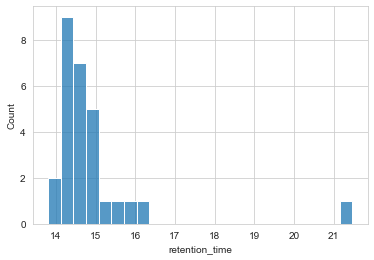

In [106]:
sns.histplot(data_hilic_confirmed.loc[data_hilic_confirmed['SMILES']=='CC1=CC=C(C=C1)OS(=O)(=O)O']['retention_time'])

In [74]:
len(data['SMILES'].unique())

350

In [61]:
data_hilic_confirmed.head()

,retention_time,comments,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
9,21.158951,5m hilic | orbitrap | beh amide | negative,13.202929,11.709699,0,0,20.712705,2.383498,4.742568,20.712705,...,9.663770,63.242131,253.052112,9.037575,535,22,88.0,100.0,6.506944,3.625000
11,21.852032,5m hilic | orbitrap | beh amide | negative,16.258866,13.992746,1,0,27.060767,2.570531,5.010168,27.060767,...,10.236633,69.916593,287.152144,6.836956,825,38,114.0,140.0,7.229167,4.736111
15,24.013674,5m hilic | orbitrap | beh amide | negative,16.876363,13.802273,1,0,26.819958,2.363597,4.727195,26.819958,...,9.931443,55.984242,318.065887,8.596375,1182,33,112.0,128.0,8.979167,4.763889
16,24.013674,5m hilic | orbitrap | beh amide | negative,16.876363,13.802273,1,0,26.819958,2.363597,4.727195,26.819958,...,9.931443,55.984242,318.065887,8.596375,1182,33,112.0,128.0,8.979167,4.763889
17,24.218681,5m hilic | orbitrap | beh amide | negative,14.470305,11.689063,1,0,25.010365,2.051411,4.102821,25.010365,...,8.687948,51.656682,296.235145,5.589342,1452,19,82.0,81.0,7.972222,5.250000


In [51]:
print("the length of the original dataset is: ", len(data_hilic))
print("the length of the new dataset is :", len(data_hilic_confirmed))

the length of the original dataset is:  1207
the length of the new dataset is : 819


In [94]:
# descriptors = pd.DataFrame()
# for index, row in data.iterrows():
#     # print(row['SMILES'])
#     temp = features_complete.loc[features_complete['SMILES'] == row['SMILES']]
#     descriptors = pd.concat([descriptors, temp], axis=0)
#     # break
# descriptors = descriptors.drop(['SMILES'], axis=1)
# descriptors.reset_index(inplace=True, drop=True)
# data.reset_index(inplace=True, drop=True)
# data_hilic = pd.concat([data['retention_time'],descriptors], axis=1)

In [52]:
data_hilic_confirmed=data_hilic_confirmed.drop(['comments'], axis = 1)

In [53]:
train, test = data_prep.make_train_test(data_hilic_confirmed)
ap.autogluon_fit_train_test(train,test, "confirmed_0.16")

Beginning AutoGluon training ...
AutoGluon will save models to "confirmed_0.16/"
AutoGluon Version:  0.4.1b20220423
Python Version:     3.9.0
Operating System:   Darwin
Train Data Rows:    650
Train Data Columns: 1224
Label Column: retention_time
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (142.92571346409505, 10.356760991096657, 66.09326, 40.78709)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5209.6 MB
	Train Data (Original)  Memory Usage: 6.36 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_m

[1000]	valid_set's rmse: 10.2087
[2000]	valid_set's rmse: 10.2021
[3000]	valid_set's rmse: 10.199
[4000]	valid_set's rmse: 10.1985
[5000]	valid_set's rmse: 10.1985
[6000]	valid_set's rmse: 10.1985
[7000]	valid_set's rmse: 10.1985
[8000]	valid_set's rmse: 10.1985
[9000]	valid_set's rmse: 10.1985
[10000]	valid_set's rmse: 10.1985


	-10.1985	 = Validation score   (root_mean_squared_error)
	233.15s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-10.807	 = Validation score   (root_mean_squared_error)
	3.47s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: CatBoost ...
	-10.1121	 = Validation score   (root_mean_squared_error)
	15.83s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-10.0834	 = Validation score   (root_mean_squared_error)
	1.43s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
		Import fastai failed. A quick tip is to install via `pip install fastai==2.*`. If you are using Mac OSX, please use this torch version to avoid compatibility issues: `pip install torch==1.6.0`.
Fitting model: XGBoost ...
	-9.7377	 = Validation score   (root_mean_squared_error)
	14.64s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-8.9122	 = Validation score  

[1000]	valid_set's rmse: 10.1111
[2000]	valid_set's rmse: 10.1073
[3000]	valid_set's rmse: 10.1073
[4000]	valid_set's rmse: 10.1073
[5000]	valid_set's rmse: 10.1073


	-10.1073	 = Validation score   (root_mean_squared_error)
	465.67s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-8.5502	 = Validation score   (root_mean_squared_error)
	0.1s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 781.21s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("confirmed_0.16/")


*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -8.550169       0.116906   58.549022                0.000178           0.103130            2       True         11
1        NeuralNetTorch  -8.912222       0.105210   31.591519                0.105210          31.591519            1       True          9
2            LightGBMXT  -9.050426       0.005904   12.216214                0.005904          12.216214            1       True          3
3               XGBoost  -9.737727       0.005614   14.638159                0.005614          14.638159            1       True          8
4         ExtraTreesMSE -10.083395       0.023428    1.432884                0.023428           1.432884            1       True          7
5         LightGBMLarge -10.107289       0.114995  465.672364                0.114995         465.

Evaluation: root_mean_squared_error on test data: -9.9199619396618
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -9.9199619396618,
    "mean_squared_error": -98.40564488433871,
    "mean_absolute_error": -6.739712097290864,
    "r2": 0.9414799488280364,
    "pearsonr": 0.9703736392987464,
    "median_absolute_error": -4.494949494845873
}


{'root_mean_squared_error': -9.9199619396618, 'mean_squared_error': -98.40564488433871, 'mean_absolute_error': -6.739712097290864, 'r2': 0.9414799488280364, 'pearsonr': 0.9703736392987464, 'median_absolute_error': -4.494949494845873}


In [107]:
train, test = data_prep.make_train_test(data_hilic)
ap.autogluon_fit_train_test(train,test, "all_features")

Beginning AutoGluon training ...
AutoGluon will save models to "all_features/"
AutoGluon Version:  0.4.1b20220423
Python Version:     3.9.0
Operating System:   Darwin
Train Data Rows:    955
Train Data Columns: 1512
Label Column: retention_time
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (196.96833749042693, 0.0563704715822627, 66.50801, 44.33481)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5097.19 MB
	Train Data (Original)  Memory Usage: 10.45 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_m

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2 -28.285040       0.055435  32.692655                0.000147           0.088039            2       True         11
1            LightGBMXT -28.382413       0.005593  15.394011                0.005593          15.394011            1       True          3
2              LightGBM -28.722768       0.005069  17.126163                0.005069          17.126163            1       True          4
3              CatBoost -28.962303       0.025101  24.283799                0.025101          24.283799            1       True          6
4               XGBoost -29.174195       0.010027  11.153360                0.010027          11.153360            1       True          8
5         ExtraTreesMSE -29.344218       0.022997   2.051186                0.022997           2.051186 

Evaluation: root_mean_squared_error on test data: -29.270446139488826
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -29.270446139488826,
    "mean_squared_error": -856.7590172047163,
    "mean_absolute_error": -17.713998976061472,
    "r2": 0.6128480548610689,
    "pearsonr": 0.785008968922323,
    "median_absolute_error": -7.651427088065702
}


{'root_mean_squared_error': -29.270446139488826, 'mean_squared_error': -856.7590172047163, 'mean_absolute_error': -17.713998976061472, 'r2': 0.6128480548610689, 'pearsonr': 0.785008968922323, 'median_absolute_error': -7.651427088065702}


In [79]:
from toolsets import classyfire

In [20]:
import toolsets.ms2_spectra_plotter as ms2plotter

i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot


In [48]:
# data_temp_include = data_temp.loc[data_temp['retention_time'].between(left_bound, right_bound, inclusive="both")]
# data_temp_exclude = data_temp.loc[~data_temp['retention_time'].between(left_bound, right_bound, inclusive="both")]

In [56]:
data_temp_include['retention_time'].describe()

count    25.000000
mean     15.943033
std       5.224142
min       9.545269
25%      14.324961
50%      14.454435
75%      14.759411
max      34.647135
Name: retention_time, dtype: float64

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/matplotlib/pyplot.py'>

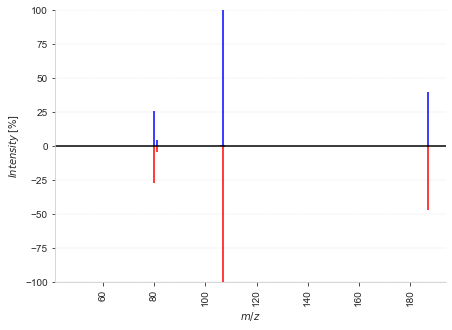

In [62]:
ms2plotter.head_to_tail_plot(data_temp_include.iloc[0]['msms'],data_temp_exclude.iloc[1]['msms'])

In [323]:
data_hilic = pd.concat([data['retention_time'],descriptors_imputed], axis=1)

In [59]:
data_hilic_confirmed

,retention_time,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,split_index
0,21.158951,13.202929,11.709699,0,0,20.712705,2.383498,4.742568,20.712705,1.218394,...,63.242131,253.052112,9.037575,535,22,88.0,100.0,6.506944,3.625000,1
1,21.852032,16.258866,13.992746,1,0,27.060767,2.570531,5.010168,27.060767,1.288608,...,69.916593,287.152144,6.836956,825,38,114.0,140.0,7.229167,4.736111,2
2,24.013674,16.876363,13.802273,1,0,26.819958,2.363597,4.727195,26.819958,1.219089,...,55.984242,318.065887,8.596375,1182,33,112.0,128.0,8.979167,4.763889,1
3,24.013674,16.876363,13.802273,1,0,26.819958,2.363597,4.727195,26.819958,1.219089,...,55.984242,318.065887,8.596375,1182,33,112.0,128.0,8.979167,4.763889,2
4,24.218681,14.470305,11.689063,1,0,25.010365,2.051411,4.102821,25.010365,1.190970,...,51.656682,296.235145,5.589342,1452,19,82.0,81.0,7.972222,5.250000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,126.192690,11.510585,10.996419,1,1,17.319018,2.230897,4.461795,17.319018,1.082439,...,47.240747,257.102824,7.141745,522,16,72.0,73.0,8.736111,3.541667,1
815,35.969883,8.485281,8.852607,0,1,15.575479,2.257545,4.515089,15.575479,1.198114,...,42.702008,186.221626,4.541991,284,16,52.0,56.0,6.062500,3.500000,1
816,126.262252,11.510585,10.996419,1,1,17.319018,2.230897,4.461795,17.319018,1.082439,...,47.240747,257.102824,7.141745,522,16,72.0,73.0,8.736111,3.541667,1
817,117.585112,6.163363,6.515899,1,3,9.335326,2.116883,4.233766,9.335326,1.037258,...,36.359125,131.069477,7.281638,96,8,36.0,36.0,5.583333,2.111111,2


In [ ]:
data_temp

In [324]:
train, test = data_prep.make_train_test(data_hilic)
ap.autogluon_fit_train_test(train,test, "seconds")

In [ ]:
# filter only query normalized entropy >0.5

In [328]:
from autogluon.tabular import TabularPredictor

In [54]:
model = TabularPredictor.load("confirmed_0.16")

In [108]:
# feature_importance = model.feature_importance(test)

These features in provided data are not utilized by the predictor and will be ignored: ['nB', 'nI', 'C2SP1', 'NsLi', 'NssBe', 'NssssBe', 'NssBH', 'NsssB', 'NssssB', 'NtCH', 'NddC', 'NssNH2', 'NsssNH', 'NsSiH3', 'NssSiH2', 'NsssSiH', 'NssssSi', 'NsPH2', 'NssPH', 'NsssP', 'NsssssP', 'NsSH', 'NdS', 'NsGeH3', 'NssGeH2', 'NsssGeH', 'NssssGe', 'NsAsH2', 'NssAsH', 'NsssAs', 'NsssdAs', 'NsssssAs', 'NsSeH', 'NdSe', 'NssSe', 'NaaSe', 'NdssSe', 'NddssSe', 'NsSnH3', 'NssSnH2', 'NsssSnH', 'NssssSn', 'NsI', 'NsPbH3', 'NssPbH2', 'NsssPbH', 'NssssPb', 'SsLi', 'SssBe', 'SssssBe', 'SssBH', 'SsssB', 'SssssB', 'StCH', 'SddC', 'SssNH2', 'SsssNH', 'SsSiH3', 'SssSiH2', 'SsssSiH', 'SssssSi', 'SsPH2', 'SssPH', 'SsssP', 'SsssssP', 'SsSH', 'SdS', 'SsGeH3', 'SssGeH2', 'SsssGeH', 'SssssGe', 'SsAsH2', 'SssAsH', 'SsssAs', 'SsssdAs', 'SsssssAs', 'SsSeH', 'SdSe', 'SssSe', 'SaaSe', 'SdssSe', 'SddssSe', 'SsSnH3', 'SssSnH2', 'SsssSnH', 'SssssSn', 'SsI', 'SsPbH3', 'SssPbH2', 'SsssPbH', 'SssssPb', 'ETA_dPsi_B', 'SMR_VSA8',

In [114]:
# data_hilic_confirmed[feature_importance.index[0:100]]

,AATS4i,Mi,AATS0i,AATSC2d,PEOE_VSA1,PEOE_VSA6,nBase,SLogP,AATS1i,NssO,...,nS,SaaN,nO,MATS1pe,ATSC1dv,NsCH3,NaasC,NaaN,SMR_VSA6,SlogP_VSA11
0,159.976945,1.110915,157.817119,-0.178209,9.843390,11.600940,0,3.81300,142.030001,1,...,0,0.000000,4,-0.047112,48.767182,2,4,0,0.000000,5.749512
1,165.757330,1.132304,164.265771,-0.087413,10.256762,5.156663,0,1.36602,150.023927,0,...,1,3.554049,3,-0.010733,8.437642,1,4,1,10.455762,0.000000
2,155.834793,1.125701,162.056397,0.128118,14.827369,32.046576,0,3.38300,145.189723,1,...,0,0.000000,3,-0.037565,65.888889,2,3,0,6.606882,0.000000
3,159.976945,1.110915,157.817119,-0.178209,9.843390,11.600940,0,3.81300,142.030001,1,...,0,0.000000,4,-0.047112,48.767182,2,4,0,0.000000,5.749512
4,159.976945,1.110915,157.817119,-0.178209,9.843390,11.600940,0,3.81300,142.030001,1,...,0,0.000000,4,-0.047112,48.767182,2,4,0,0.000000,5.749512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,174.410047,1.156424,170.739620,-0.152585,28.636992,0.000000,1,-1.45260,152.748491,2,...,0,0.000000,6,-0.238196,-18.865379,3,0,0,47.508418,0.000000
815,162.212684,1.148897,168.547966,-0.063103,4.483031,19.765380,1,3.44320,148.910487,0,...,0,0.000000,0,0.185914,13.511005,4,0,0,26.179026,0.000000
816,174.410047,1.156424,170.739620,-0.152585,28.636992,0.000000,1,-1.45260,152.748491,2,...,0,0.000000,6,-0.238196,-18.865379,3,0,0,47.508418,0.000000
817,176.167274,1.175544,176.447725,-0.186372,15.740105,0.000000,3,-1.10373,164.440768,0,...,0,0.000000,2,-0.262522,16.987654,1,0,0,13.592428,0.000000


In [277]:
x_train=train.drop(['retention_time'], axis=1)
y_train = train['retention_time']

In [152]:
x_test = test.drop(['retention_time'], axis=1)
y_test = test['retention_time']

In [154]:
model = TabularPredictor.load('subset_by_compounds')

In [155]:
y_pred = model.predict(x_test)

<AxesSubplot:xlabel='retention_time', ylabel='retention_time'>

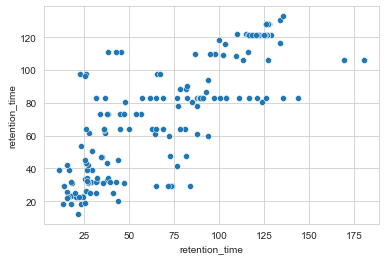

In [156]:
sns.scatterplot(y_test, y_pred)
# sns.scatterplot(y_train, y_train_pred)

In [157]:
import math
MSE = np.square(np.subtract(y_test,y_pred)).mean()

RMSE = math.sqrt(MSE)

In [158]:
print(MSE, RMSE)

454.7100326573845 21.323930985101796
